In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np

# visualize the osm objects within a chip

In [2]:
folder = '/opt/data/california-naip-chips/osm/'
files = os.listdir(folder)

file = np.random.choice(files)
z = gpd.read_parquet(f"{folder}/{file}")
z.explore()

## inspect and visualize the neighbours of a chip

In [3]:
folder = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours"
files = os.listdir(folder)
file = np.random.choice(files)
print(file)

z = pd.read_parquet(f"{folder}/{file}")
z

ca_m_3411849_ne_11_060_20220513-21-33.parquet


,chipid,lonm,latm,embeddings,distance
821,ca_m_3411849_ne_11_060_20220513-21-20,1.755404e+06,731286.686970,"[-0.108233936, 0.010846007, 0.1093552, 0.01474...",1996.985343
856,ca_m_3411849_ne_11_060_20220513-16-21,1.754635e+06,731138.267167,"[-0.124075174, 0.014255269, 0.12636358, 0.0298...",1996.981614
857,ca_m_3411849_ne_11_060_20220513-17-21,1.754789e+06,731137.229026,"[-0.12260792, 0.017274845, 0.13649453, 0.00954...",1943.080760
858,ca_m_3411849_ne_11_060_20220513-18-21,1.754942e+06,731136.190827,"[-0.12030384, 0.020596614, 0.13030219, 0.00744...",1900.101154
859,ca_m_3411849_ne_11_060_20220513-19-21,1.755096e+06,731135.152569,"[-0.1056956, 0.015963135, 0.13591257, 0.006640...",1868.796491
...,...,...,...,...,...
22,ca_m_3411849_se_11_060_20220513-22-0,1.755400e+06,727422.279083,"[-0.13937744, 0.04233083, 0.0650124, 0.0373163...",1867.489695
23,ca_m_3411849_se_11_060_20220513-23-0,1.755553e+06,727421.238162,"[-0.13077426, 0.043095883, 0.07634795, 0.01508...",1875.567630
24,ca_m_3411849_se_11_060_20220513-24-0,1.755707e+06,727420.197184,"[-0.12949172, 0.037134435, 0.1115681, 0.011802...",1896.097165
25,ca_m_3411849_se_11_060_20220513-25-0,1.755860e+06,727419.156151,"[-0.14536558, 0.034056127, 0.090573534, 0.0084...",1928.680748


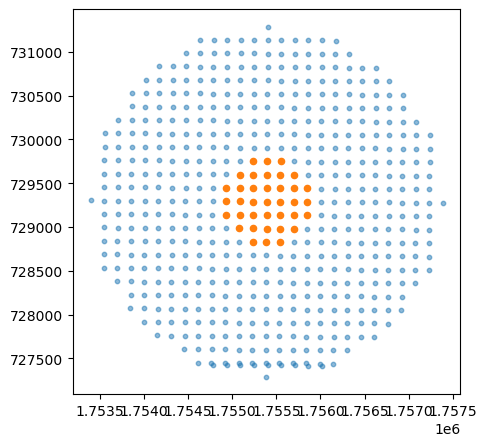

In [4]:
plt.figure(figsize=(5,5));
plt.scatter(z.lonm.values, z.latm.values, alpha=.5, s=10);
zz = z[z.distance<500]
plt.scatter(zz.lonm.values, zz.latm.values, s=20);

---

# Deduplicate the grid of neighbours

In [5]:
# Compute all pair-wise distances. Needed to find the average distance to a neighbor (exluding duplicates).

_center = z[z['distance'] == 0][['lonm', 'latm']].values[0]
z[['lonm', 'latm']] -= _center

n = z.shape[0]
X = z[['lonm', 'latm']].values  # coordinates
# distance matrix
XXt = X@X.T
L2 = np.diag(XXt)  # vector of squared lengths
_1_L2 = np.tile(L2, (n, 1))
L2_1 = _1_L2.T
D = np.sqrt(_1_L2 + L2_1 - 2*XXt)  # distance matrix

# find the pairs with distance smaller than 150m

D_triu = np.triu(D)

i_nodes = np.unique(np.concatenate(np.nonzero((1 < D_triu) & (D_triu < 150))))

In [6]:
# histogram of distances
# counts, binedges, _ = plt.hist(D_triu[(400 > D_triu) & (D_triu > 0)], bins=400);
counts, binedges = np.histogram(D_triu[(400 > D_triu) & (D_triu > 0)], bins=400);

i_bin = np.nonzero(counts > 500)[0][0]
edges = binedges[i_bin:i_bin + 2]
dist_nb = edges.mean()
bin_edges = np.arange(-13.5, 14.5, 1) * dist_nb
print(edges)
print(dist_nb)

[152.99668679 153.85275273]
153.42471975822014


In [7]:
# # Highlight pairs with small distances (< dist_nb)

# plt.figure(figsize=(10,10));
# plt.scatter(X[:,0], X[:,1], alpha=.5, s=10);
# zz = X[i_nodes]
# plt.scatter(zz[:,0], zz[:,1], s=20);

# for _edge in bin_edges:
#     plt.axvline(_edge, c='gray', alpha=.3)
#     plt.axhline(_edge, c='gray', alpha=.3)
# plt.xlim(bin_edges.min(), bin_edges.max())
# plt.ylim(bin_edges.min(), bin_edges.max())

# # ID pairs
# # IX = np.stack(np.nonzero((1 < D_triu) & (D_triu < 150)), axis=1)
# print(IX.shape)

#### Histogram on the same edges

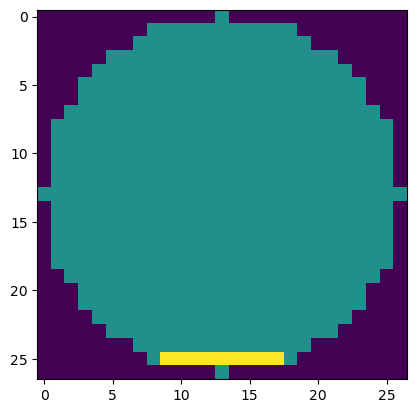

In [8]:
h, _xedges, _yedges = np.histogram2d(X[:,0], X[:,1], bins=(bin_edges, bin_edges));
plt.imshow(np.rot90(h));

In [9]:
ixbin = np.digitize(X[:,0], bin_edges) - 1
iybin = np.digitize(X[:,1], bin_edges) - 1
ibin = np.stack([ixbin, iybin], axis=1)  # grid indices of all chips
# ixbin = np.clip(ixbin, 0, h.shape[0]-1)
# iybin = np.clip(iybin, 0, h.shape[1]-1)
c = h[ixbin, iybin]

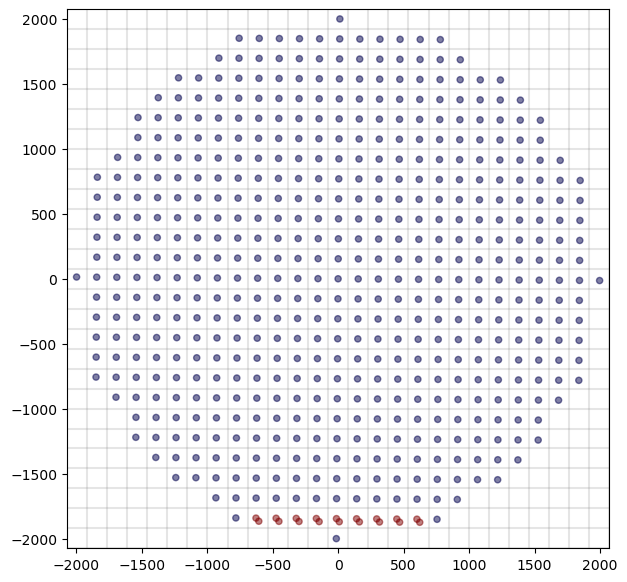

In [10]:
# Highlight grid-cells with more than one chip

plt.figure(figsize=(7,7));
plt.scatter(X[:,0], X[:,1], c=c, alpha=.5, s=20, cmap='seismic');
for _edge in bin_edges:
    plt.axvline(_edge, c='gray', alpha=.2)
    plt.axhline(_edge, c='gray', alpha=.2)
plt.xlim(bin_edges.min(), bin_edges.max());
plt.ylim(bin_edges.min(), bin_edges.max());

In [11]:
# remove excess chips, from cells with high count (>1)

_, unique_indices, _ = np.unique(ibin, axis=0, return_index=True, return_counts=True)

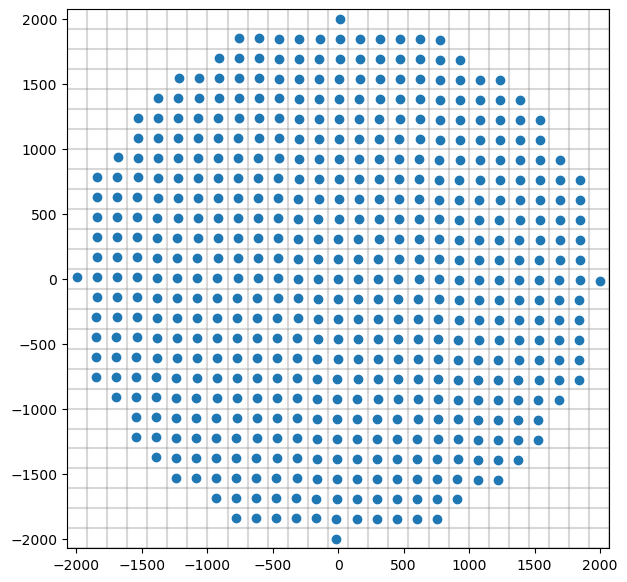

In [12]:
# De-duplicated neighborhood 

plt.figure(figsize=(7,7));
plt.scatter(X[unique_indices,0], X[unique_indices,1])#, alpha=.5, s=30, cmap='seismic');
for _edge in bin_edges:
    plt.axvline(_edge, c='gray', alpha=.3)
    plt.axhline(_edge, c='gray', alpha=.3)
plt.xlim(bin_edges.min(), bin_edges.max());
plt.ylim(bin_edges.min(), bin_edges.max());

---

#### Is there a contiguous square grid around the center chip?

Is the square contiguous? -- True
chip width: 0.921 km
chip area: 0.847 sqkm


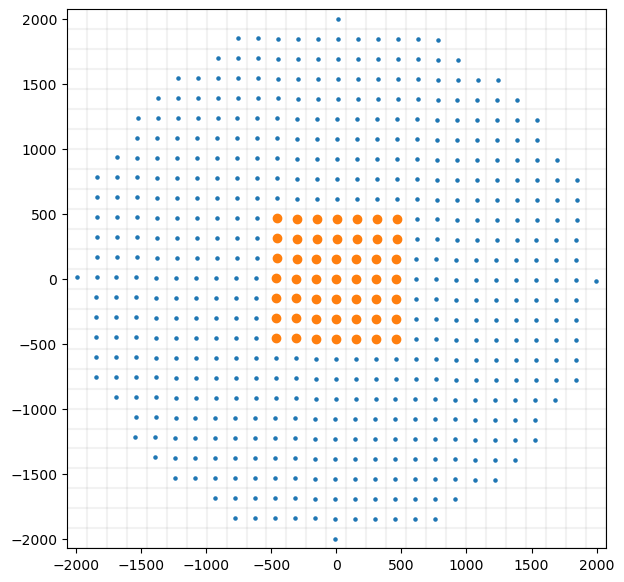

In [13]:
W = 7
_range = np.arange(-(W//2), (W//2) + 1)
indices_in_square = np.array([[13 + i, 13 + j] for i in _range for j in _range])

mask_unique_bins_in_square = np.isin(ibin[unique_indices], indices_in_square).all(axis=1)
mask_center_bin = (ibin == [13, 13]).all(axis=1)
# center_bin_coords = X[mask_center_bin][0]

print(f"Is the square contiguous? -- {h[*indices_in_square.T].all()}")
print(f"chip width: {dist_nb * (W-1) / 1000:.3f} km")
print(f"chip area: {(dist_nb * (W-1) / 1000)**2:.3f} sqkm")

plt.figure(figsize=(7, 7));
plt.scatter(*X[unique_indices].T, s=5);  plt.axis('square');
plt.scatter(*X[unique_indices][mask_unique_bins_in_square].T);

for _edge in bin_edges:
    plt.axvline(_edge, c='gray', alpha=.1); plt.axhline(_edge, c='gray', alpha=.1);
plt.xlim(bin_edges.min(), bin_edges.max()); plt.ylim(bin_edges.min(), bin_edges.max());

---

In [14]:
# Deduplicated slice of the original dataframe
z.iloc[unique_indices]

,chipid,lonm,latm,embeddings,distance
1328,ca_m_3411849_ne_11_060_20220513-8-33,-1996.926082,13.510438,"[-0.123818465, 0.03175875, 0.10171221, 0.01966...",1996.971785
1529,ca_m_3411849_ne_11_060_20220513-9-38,-1848.513051,-755.573418,"[-0.14370728, 0.037456572, 0.14170125, 0.02155...",1996.970628
1489,ca_m_3411849_ne_11_060_20220513-9-37,-1847.473634,-601.964545,"[-0.14939567, 0.03485481, 0.13031043, 0.015973...",1943.069773
1449,ca_m_3411849_ne_11_060_20220513-9-36,-1846.434321,-448.355615,"[-0.13721761, 0.045402545, 0.12199549, -0.0018...",1900.090119
1409,ca_m_3411849_ne_11_060_20220513-9-35,-1845.395112,-294.746628,"[-0.15687491, 0.04978406, 0.12152502, -0.00516...",1868.785352
...,...,...,...,...,...
1273,ca_m_3411849_ne_11_060_20220513-33-31,1845.412242,294.743546,"[-0.14188382, 0.04606688, 0.11173097, 0.001645...",1868.801782
1233,ca_m_3411849_ne_11_060_20220513-33-30,1846.452312,448.355284,"[-0.14524381, 0.04783606, 0.11923027, 0.008882...",1900.107523
1193,ca_m_3411849_ne_11_060_20220513-33-29,1847.492279,601.967081,"[-0.13210475, 0.045215104, 0.12644933, 0.00810...",1943.088286
1153,ca_m_3411849_ne_11_060_20220513-33-28,1848.532145,755.578935,"[-0.13392347, 0.042562444, 0.11419071, 0.00084...",1996.990390


(49, 5)
(49, 768)


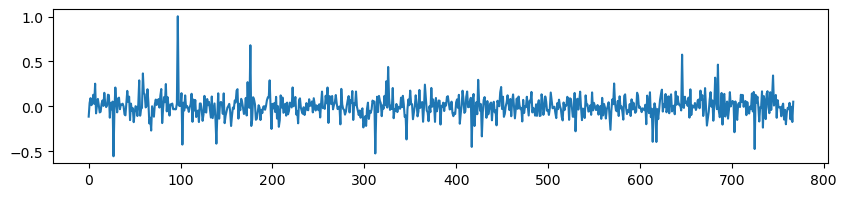

In [15]:
# Square-grid slice of the df
z_sq = z.iloc[unique_indices].iloc[mask_unique_bins_in_square]
print(z_sq.shape)

# Get the square grid neighborhood embeddings 

E = np.stack(z_sq['embeddings'].values)
print(E.shape)

plt.figure(figsize=(10,2));
plt.plot(E.mean(axis=0));

# Putting it all together

In [16]:
def deduplicate_neighbors(df):

    W = 7

    # Compute all pair-wise distances. Needed to find the average distance to a neighbor (exluding duplicates).
    _center = df[df['distance'] == 0][['lonm', 'latm']].values[0]
    df[['lonm', 'latm']] -= _center
    X = df[['lonm', 'latm']].values  # coordinates

    # Compute distance matrix
    XXt = X@X.T
    L2 = np.diag(XXt)  # vector of squared lengths
    n = z.shape[0]
    _1_L2 = np.tile(L2, (n, 1))
    L2_1 = _1_L2.T
    D = np.sqrt(_1_L2 + L2_1 - 2*XXt)  # distance matrix
    D_triu = np.triu(D)

    # histogram of distances
    counts, binedges = np.histogram(D_triu[(400 > D_triu) & (D_triu > 0)], bins=400);
    i_bin = np.nonzero(counts > 500)[0][0]
    edges = binedges[i_bin:i_bin + 2]
    dist_nb = edges.mean()
    bin_edges = np.arange(-13.5, 14.5, 1) * dist_nb
   
    ixbin = np.digitize(X[:,0], bin_edges) - 1
    iybin = np.digitize(X[:,1], bin_edges) - 1
    ibin = np.stack([ixbin, iybin], axis=1)  # grid indices of all chips

    # remove excess chips, from cells with high count (>1)
    _, unique_indices, _ = np.unique(ibin, axis=0, return_index=True, return_counts=True)
    
    _range = np.arange(-(W//2), (W//2) + 1)
    indices_in_square = np.array([[13 + i, 13 + j] for i in _range for j in _range])
    mask_unique_bins_in_square = np.isin(ibin[unique_indices], indices_in_square).all(axis=1)

    return df.iloc[unique_indices], unique_indices, mask_unique_bins_in_square

In [17]:
z_dedup, _unique_indices, _mask_unique_bins_in_square = deduplicate_neighbors(z)

In [18]:
print((z_dedup == z.iloc[unique_indices]).all().all())
print((_unique_indices == unique_indices).all())
print((_mask_unique_bins_in_square == mask_unique_bins_in_square).all())

True
True
True


(49, 5)
True
(49, 768)


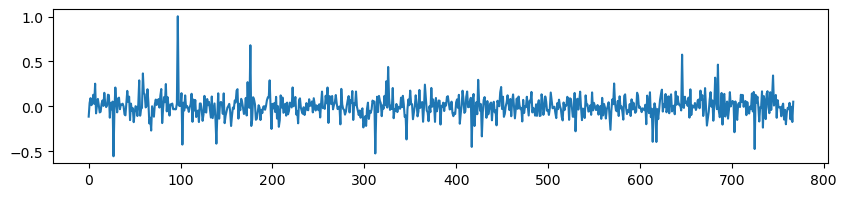

In [19]:
# Square-grid slice of the df
_z_sq = z_dedup.iloc[mask_unique_bins_in_square]
print(z_sq.shape)
print((_z_sq == z_sq).all().all())

# Get the square grid neighborhood embeddings 
E = np.stack(_z_sq['embeddings'].values)
print(E.shape)

plt.figure(figsize=(10,2));
plt.plot(E.mean(axis=0));